In [1]:
using Pkg
Pkg.add("Plots")

    Updating registry at `C:\Users\ASUS\.julia\registries\General`


    Updating

 git-repo `https://github.com/JuliaRegistries/General.git`


   Resolving package versions...


  No Changes to `C:\Users\ASUS\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\ASUS\.julia\environments\v1.6\Manifest.toml`

In [2]:
using Plots
gr()

Plots.GRBackend()

#### Nạp chồng toán tử

In [3]:
Base.:(==)(s1::Tuple{Int,Int}, s2::Tuple{Int,Int}) = (s1[1] == s2[1]) && (s1[2] == s2[2])
Base.:+(s1::Tuple{Int,Int}, s2::Tuple{Int,Int}) = (s1[1] + s2[1], s1[2] + s2[2])
Base.:-(s1::Tuple{Int,Int}, s2::Tuple{Int,Int}) = (s1[1] - s2[1], s1[2] - s2[2])
Base.:(==)(s1::Tuple{Tuple{Int,Int},Tuple{Int,Int}}, s2::Tuple{Tuple{Int,Int},Tuple{Int,Int}}) = (s1[1] == s2[1]) && (s1[2] == s2[2])
Base.:(==)(s1::Tuple{Tuple{Int,Int},Tuple{Int,Int},Tuple{Int,Int}}, s2::Tuple{Tuple{Int,Int},Tuple{Int,Int},Tuple{Int,Int}}) = (s1[1] == s2[1]) && (s1[2] == s2[2]) && (s1[3] == s2[3])


#### Nạp chồng toán tử in để kiểm tra xem 1 điểm có nằm trong Dictionary

In [4]:
function check_key(key::Tuple{Tuple{Int,Int},Tuple{Int,Int},Tuple{Int,Int}}, dic::Dict)
    if key in keys(dic)
        return true
    end
    return false
end
function check_key(key::Tuple{Tuple{Int,Int},Tuple{Int,Int}}, dic::Dict)
    if key in keys(dic)
        return true
    end
    return false
end
function check_key(key::Tuple{Int,Int}, dic::Dict)
    if key in keys(dic)
        return true
    end
    return false
end

check_key (generic function with 3 methods)

#### Các hàm hỗ trợ khác

In [5]:
function turn_left_index(s::Tuple{Int,Int},a::Tuple{Int,Int})
    val = findfirst(u -> u == a,hex_neighbors(s))
    return mod1(val+1, 6)
end
function turn_right_index(s::Tuple{Int,Int},a::Tuple{Int,Int})
    val = findfirst(u -> u == a,hex_neighbors(s))
    return mod1(val-1, 6)
end
function check_in(a::Tuple{Int,Int},b)
    for tmp in b
        if a == tmp
            return true
        end
    end
    return false
end

check_in (generic function with 1 method)

#### Thông số liên quan phục vụ cho cấu hình MDP

In [6]:
#Ra khỏi map 
out_border = -1
#T(s,a,s')
#Tuple{Tuple{Int,Int},Tuple{Int,Int},Tuple{Int,Int}} -> Float64
dict_T = Dict()
#R(s)
#Tuple{Int,Int} -> Float64
dict_R = Dict()
#--------------------------------------------------------------

Dict{Any, Any}()

#### Tính toán T và R

In [7]:

function calc_transition_and_reward_dict(hexes::Vector{Tuple{Int,Int}},p_straight, hex_rewards)
    null_state = (-100,-100)
    #Tỉ lệ quyết định việc rẽ trái hoặc rẽ phải
    p_turn = (1-p_straight)/2
    for s in filter(u -> u != null_state,hexes)
        if !haskey(hex_rewards,s)
            neighbors = hex_neighbors(s)
            for a in neighbors
                s′ = a
                if !(check_in(s′,hexes))
                    #Đi thẳng
                    if check_key(s,dict_R)
                        s′ = s 
                        dict_R[s] += out_border*p_straight
                    else 
                        dict_R[s] = out_border*p_straight
                    end
                end
                if check_key((s,a-s,s′),dict_T)
                    dict_T[(s,a-s,s′)] += p_straight
                else
                    dict_T[(s,a-s,s′)] = p_straight
                end


                #Đi trái
                a_left = turn_left_index(s,a)
                neigh_left = neighbors[a_left]
                s′ = neigh_left
                if !(check_in(s′,hexes))
                    if check_key(s,dict_R)
                        s′ = s
                        dict_R[s] += out_border*p_turn
                    else
                        dict_R[s] = out_border*p_turn
                    end
                end
                if check_key((s,neigh_left-s,s′),dict_T)
                    dict_T[(s,neigh_left-s,s′)] += p_turn
                else
                    dict_T[(s,neigh_left-s,s′)] = p_turn
                end
                
                #Đi phải
                a_right = turn_right_index(s,a)
                neigh_right = neighbors[a_right]
                s′ = neigh_right
                if !(check_in(s′,hexes))
                    if check_key(s,dict_R)
                        s′ = s
                        dict_R[s] += out_border*p_turn
                    else
                        dict_R[s] = out_border*p_turn
                    end
                end
                if check_key((s,neigh_right-s,s′),dict_T)
                    dict_T[(s,neigh_right-s,s′)] += p_turn
                else
                    dict_T[(s,neigh_right-s,s′)] = p_turn
                end
            end
        else
            for a in action
                dict_T[(s,a,null_state)] = 1.0
                if check_key(s,dict_R)
                    dict_R[s] += hex_rewards[s]
                else
                    dict_R[s] = hex_rewards[s]
                end
            end
        end
    end
    for a in action
        dict_T[(null_state,a,null_state)] = 1.0
    end
end

calc_transition_and_reward_dict (generic function with 1 method)

#### Cấu hình của MDP

In [8]:
struct MDP
    γ
    𝒮
    𝒜
    T 
    R
    TR
end
MDP(γ, 𝒮, 𝒜, T, R) = MDP(γ, 𝒮, 𝒜, T, R, nothing)
function lookahead(P::MDP, U, s, a)
    S, T, R, γ = P.S, P.T, P.R, P.γ
    return R(s,a) + γ*sum(T(s,a,s′)*U(s′) for s′ in S)
end


function lookahead(𝒫::MDP, U::Vector, s, a)
    𝒮, T, R, γ = 𝒫.𝒮, 𝒫.T, 𝒫.R, 𝒫.γ
    return R(s,a) + γ*sum(T(s,a,s′)*U[i] for (i,s′) in enumerate(𝒮))
end

lookahead (generic function with 2 methods)

#### Thông số cho MDP (nếu chỉnh thì sẽ chỉnh state, discount_factor)

In [9]:
#State
state =  [(2,1), (3,1), (4,1), (5,1), (6,1), (7,1), (8,1), (9,1), (10,1), (11,1),
(2,2), (3,2), (4,2), (6,2), (9,2), (10,2),
(1,3), (2,3), (3,3), (4,3), (6,3), (8,3), (10,3)]
#Discount factor
discount_factor = 0.85
function T(s,a,s′)
    if !check_key((s,a,s′), dict_T)
        return 0
    end
    return dict_T[(s,a,s′)]
end
function R(s,a=missing)
    if !check_key(s, dict_R)
        return 0
    end
    return dict_R[s]
end
#action
action =[(1,0),(0,1),(-1,1),(-1,0),(0,-1),(1,-1)]
function hex_neighbors(hex::Tuple{Int,Int})
    i,j = hex
    [(i+1,j),(i,j+1),(i-1,j+1),(i-1,j),(i,j-1),(i+1,j-1)]
end

hex_neighbors (generic function with 1 method)

#### ValueFunctionPolicy

In [10]:
struct ValueFunctionPolicy
    𝒫
    U # result
end
function greedy(𝒫::MDP, U, s)
    u, a = findmax(a->lookahead(𝒫, U, s, a), 𝒫.𝒜)
    return (a=a, u=u)
end
(π::ValueFunctionPolicy)(s) = action[greedy(π.𝒫, π.U, s).a]


function backup(𝒫::MDP, U, s)
    return maximum(lookahead(𝒫, U, s, a) for a in 𝒫.𝒜)
end

backup (generic function with 1 method)

#### Thuật toán Value Iteration

In [11]:
struct ValueIteration
    k_max # số lần duyệt
end
    
function solve(M::ValueIteration, 𝒫::MDP)
    U = [0.0 for s in 𝒫.𝒮]
    for k = 1:M.k_max
        U = [backup(𝒫, U, s) for s in 𝒫.𝒮]
    end
    return ValueFunctionPolicy(𝒫, U)
end

solve (generic function with 1 method)

#### Phần tính toán Value Iteration

In [12]:
#Phần thưởng đạt được
hex_rewards = Dict{Tuple{Int,Int}, Float64}(
    (2,2) =>  5.0,
    (3,3) => -10.0,
    (10,3) =>  10.0,
)

#Tỉ lệ quyết định đi thẳng
p_straight = 0.7
calc_transition_and_reward_dict(state,p_straight,hex_rewards)

VI = ValueIteration(20)
Problem = MDP(discount_factor,state,action,T,R)
value = solve(VI,Problem).U

23-element Vector{Float64}:
  21.5
  23.5
  19.675
  14.57375
  10.415172812499998
  15.782556249999999
  22.097125
  30.7025
  39.65
  37.65
   ⋮
  39.65
  49.0
  21.5
  23.5
 -60.0
  13.57375
   3.852896890624998
  28.7025
  60.0

#### Phần vẽ đồ thị

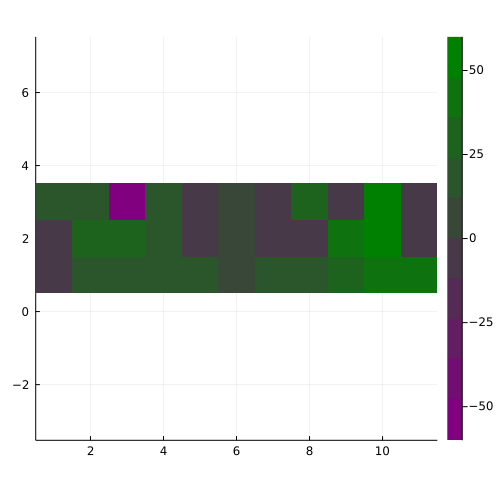

In [13]:
#0 + 1 để dời cho việc vẽ heatmap
#-1
a = maximum([k[1] for k in state])
b = maximum([k[2] for k in state])

xs = [i for i in 1:a]
ys = [i for i in 1:b]

z = zeros(b,a)
for i in 1:length(state)
    x,y = state[i]
    z[y,x] = value[i]
end
heatmap(xs,ys,z,aspect_ratio=1,c=palette([:purple, :green], 10),size=(500,500))

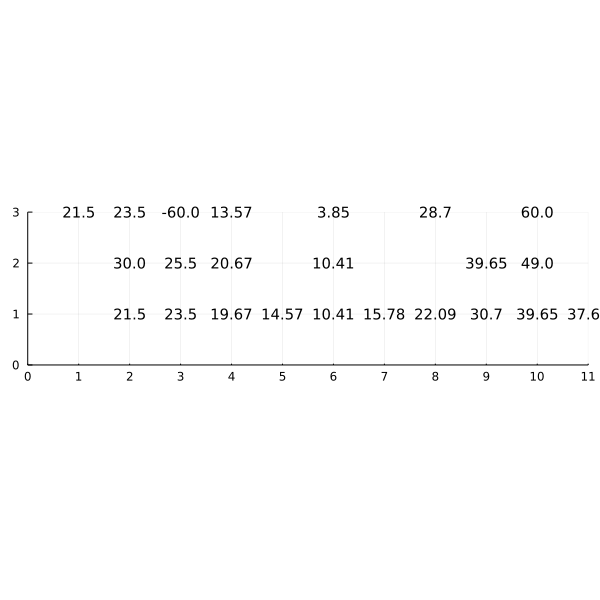

In [14]:
hex_rewards = Dict{Tuple{Int,Int}, Float64}(
    (2,2) =>  5.0,
    (3,3) => -10.0,
    (10,3) =>  10.0,
)
plot(xticks = 0:a, yticks = 0:b, xlim = (0, a), ylim = (0,b), aspect_ratio = 1, annotationfontsize=10, size=(600,600))
annotate!(map(x -> x[1],state),map(x -> x[2],state),map(x -> floor(x,digits=2),value))

#### Đánh giá Monte Carlo

In [15]:
function step(start)
    sumExUtil = 0
    count = 0 
    decider = start
    maxReward = 0
    
    while true
        flagStop = 1
        neighbors = hex_neighbors(decider)
        for neigh in neighbors
            if check_in(neigh,state)
                tmpIndex = findfirst(x -> x == neigh, state) 
                if value[tmpIndex] >= maxReward
                    decider = neigh
                    maxReward = value[tmpIndex]
                    flagStop = 0
                end
            end  
        end
        sumExUtil += maxReward
        count += 1
        if flagStop == 1
            break
        end
    end
    return sumExUtil / count
end


step (generic function with 1 method)

In [16]:
function monte_carlo_evaluation(times)
    result = 0
    randomIndex = -1
    while true
        randomIndex = rand(1:length(state))    
        check_key(state[randomIndex],hex_rewards) || break    
    end
    for i in 1:times 
        result += step(state[randomIndex])    
    end
    return result/times
end


monte_carlo_evaluation (generic function with 1 method)

In [17]:
times = 1000000
finalAnswer = 0
iteration = 10
for i in 1:iteration
    evalValue = monte_carlo_evaluation(times)
    finalAnswer += evalValue
    println(evalValue," ")
end
println("After ",iteration," iterations: ", finalAnswer/iteration)

52.162500000926265 


26.543749999531954 


52.162500000926265 


26.543749999531954 


39.6045973220133 


26.543749999531954 


56.33333333404171 


28.5 


56.33333333404171 


26.543749999531954 
After 10 iterations: 39.12712639900771
